# (19) rotation — conv model

**Motivation**: host = ```Any```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: mach

In [3]:
from analysis.rotation import *


def _plot(rotation_results, which: str = 'mse_latent'):
    if which == 'mse_latent':
        num_rounds = kws['num_rounds']
        figsize_x = 2.4 * num_rounds
    else:
        num_rounds = 1
        figsize_x = 4
    fig, axes = create_figure(2, 1, figsize=(figsize_x, 5), sharex='all')
    
    d2p = rotation_results['iter-pois'][which]
    perf = np.mean(list(d2p.values())[1:])
    for ax in axes.flat:
        ax.axhline(perf, ls='--', color='k')

    pal = {'iter-pois': 'k', 'amort-pois': 'r'}
    for i, (name, color) in enumerate(pal.items()):
        d2p = rotation_results[name][which]
        perf = list(d2p.values())
        if which == 'mse_latent':
            perf = np.mean(perf[1:])
        else:
            perf = np.mean(perf[1:-1])
        axes[i].plot(d2p.keys(), d2p.values(), label=name, marker='o', color=color)
        axes[i].set_title(f"{name}, avg mse = {perf:0.1f}")

    for ax in axes.flat:
        ax.set(xticks=list(d2p.keys()))
        ax.tick_params(axis='x', rotation=-90)
        for i in range(num_rounds):
            ax.axvspan(
                i * 360, (i + 1) * 360,
                color=f'C{i}', alpha=0.1,
            )
    fig.suptitle(r"$\Delta \theta = $" + f"{kws['delta_theta']}", fontsize=17)
    axes[1].set_xlabel(r"$\theta$", fontsize=15)
    add_legend(axes, loc='lower center')
    add_grid(axes)
    plt.show()

## Poisson

- MNIST
- ```conv```

In [4]:
models2load = {
    'iter-pois': dict(
        model_name='poisson_MNIST_t-16_z-[128]_k-32_<jacob|conv>',
        fit_name='b200-ep400-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_17,09:34)',
        device=device,
        shuffle=False,
    ),
    'amort-pois': dict(
        model_name='poisson_MNIST_t-1_z-[128]_k-32_<conv|conv>',
        fit_name='b200-ep400-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_18,19:56)',
        device=device,
        shuffle=False,
    )
}

In [5]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}
tr = trainers['iter-pois']

### Rotate

### latent rotation

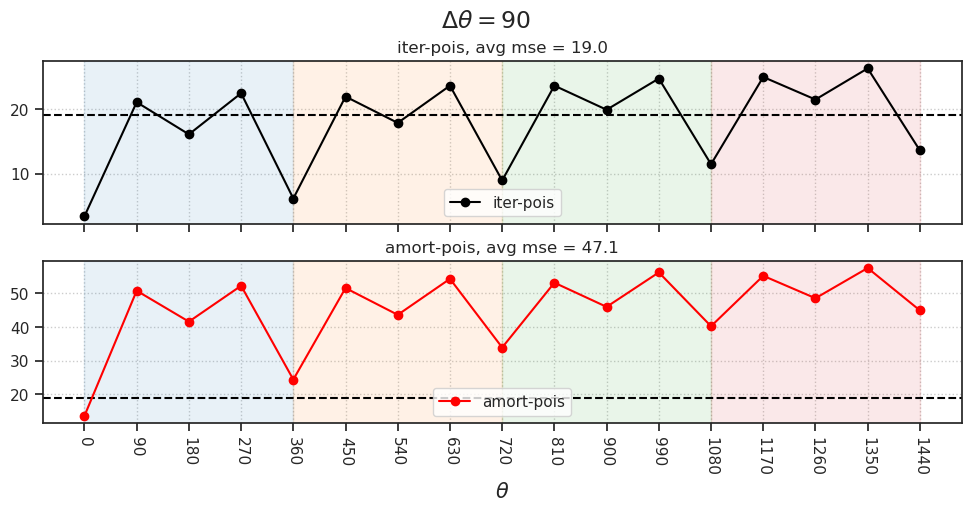

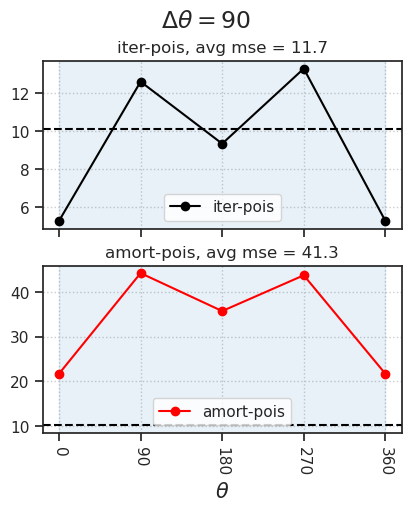

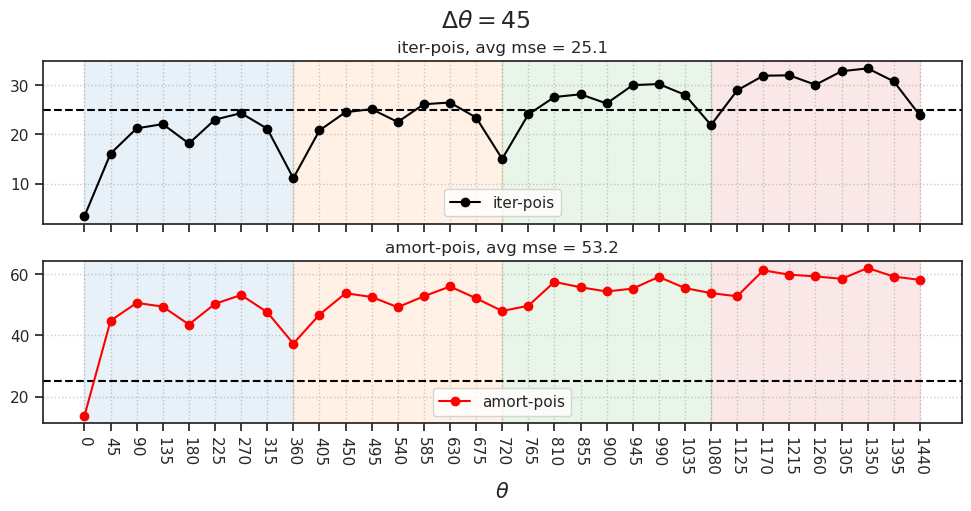

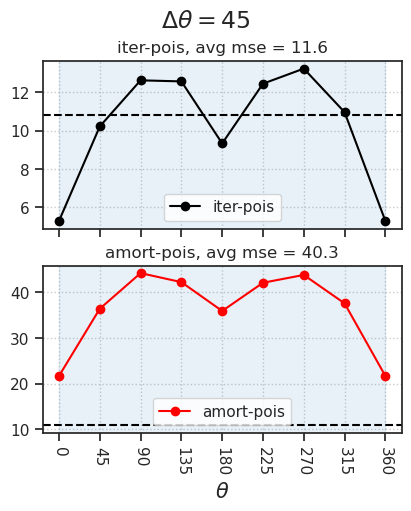

CPU times: user 28min 55s, sys: 9.18 s, total: 29min 4s
Wall time: 27min 17s


In [6]:
%%time

kws = dict(num_rounds=4, use_rates=True, t=-1)

rotation_results_all = {}
for delta_theta in [90, 45]:
    kws['delta_theta'] = delta_theta
    rotation_results = {
        name: latent_rotation_analysis(tr, **kws)
        for name, tr in trainers.items()
    }
    rotation_results_all[delta_theta] = rotation_results

    _plot(rotation_results, 'mse_latent')
    _plot(rotation_results, 'mse_pixel_vld')

### slow rotation

In [43]:
kws = dict(spacing=0.01, num_rounds=1, n_data_batches=1)

results_iter, angles = slow_rotate_batch(trainers['iter-pois'], reset=False, **kws)
results_amort, angles = slow_rotate_batch(trainers['amort-pois'], reset=True, **kws)

100%|█████████████████████████████████████| 36000/36000 [15:17<00:00, 39.22it/s]


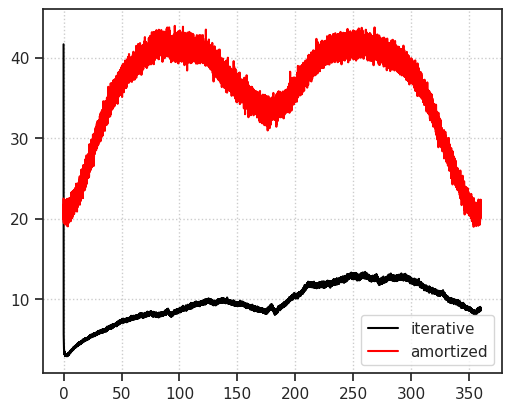

In [44]:
fig, ax = create_figure(1, 1, (5, 4))
ax.plot(angles, tonp(results_iter['mse'].mean(0)), label='iterative', color='k')
ax.plot(angles, tonp(results_amort['mse'].mean(0)), label='amortized', color='r')
add_legend(ax)
add_grid(ax)
plt.show()

100%|█████████████████████████████████| 360000/360000 [1:01:59<00:00, 96.80it/s]


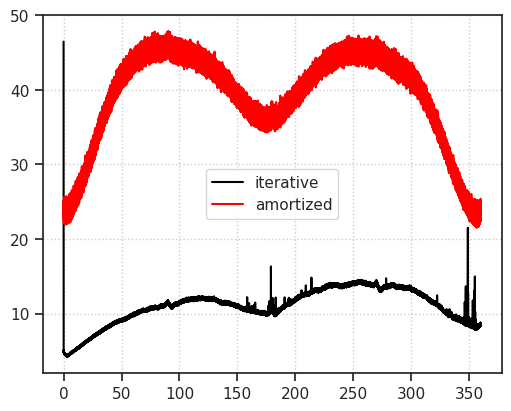

### generate

In [6]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

In [7]:
n_iters = 200
output = tr.model.generate(pred, seq=range(n_iters))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['loss_kl', 'loss_recon', 'dist', 'ff', 'recon', 'state', 'samples']

In [8]:
shape = (n_samples, *tr.model.cfg.input_sz[1:])
pred = pred.reshape(shape)

shape_y = (n_samples, n_iters, *tr.model.cfg.input_sz[1:])
y = output['recon'].reshape(shape_y)

pred.shape, y.shape

(torch.Size([64, 28, 28]), torch.Size([64, 200, 28, 28]))

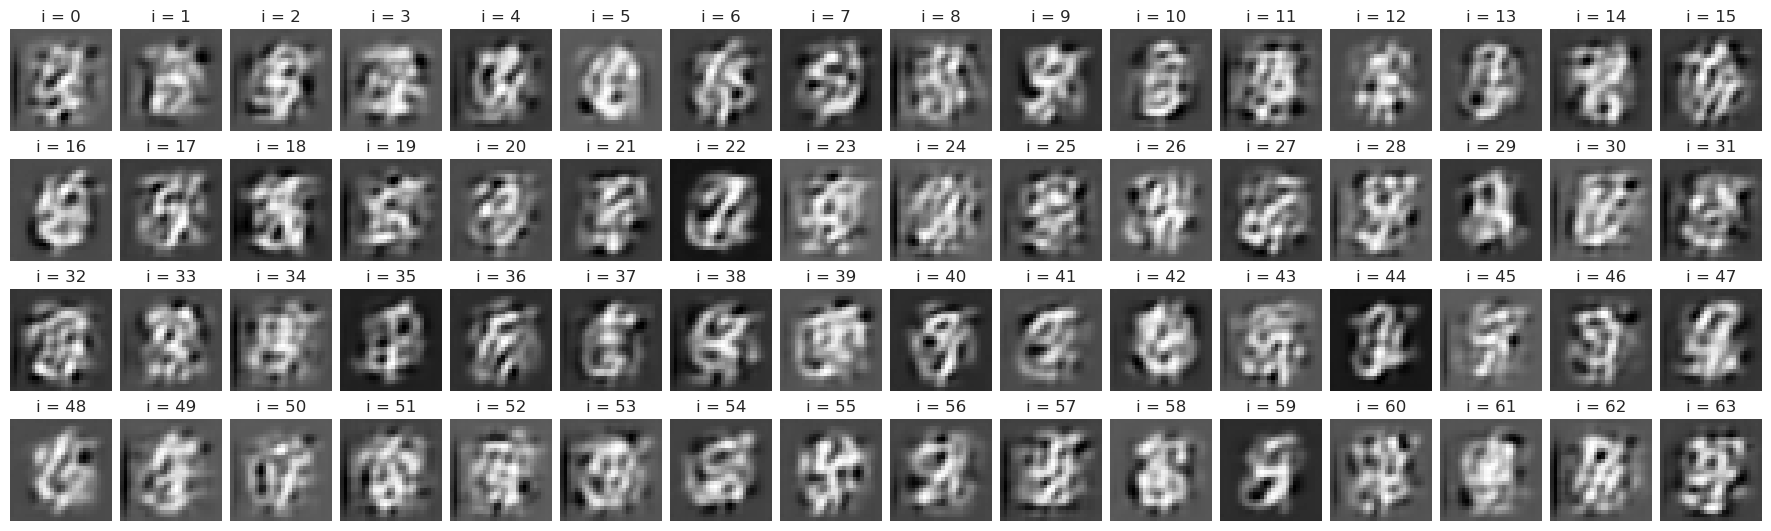

In [9]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')

for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    
    x2p = tonp(pred[sample_i])
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")

trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [12]:
order = np.argsort(desc_len)[::-1]

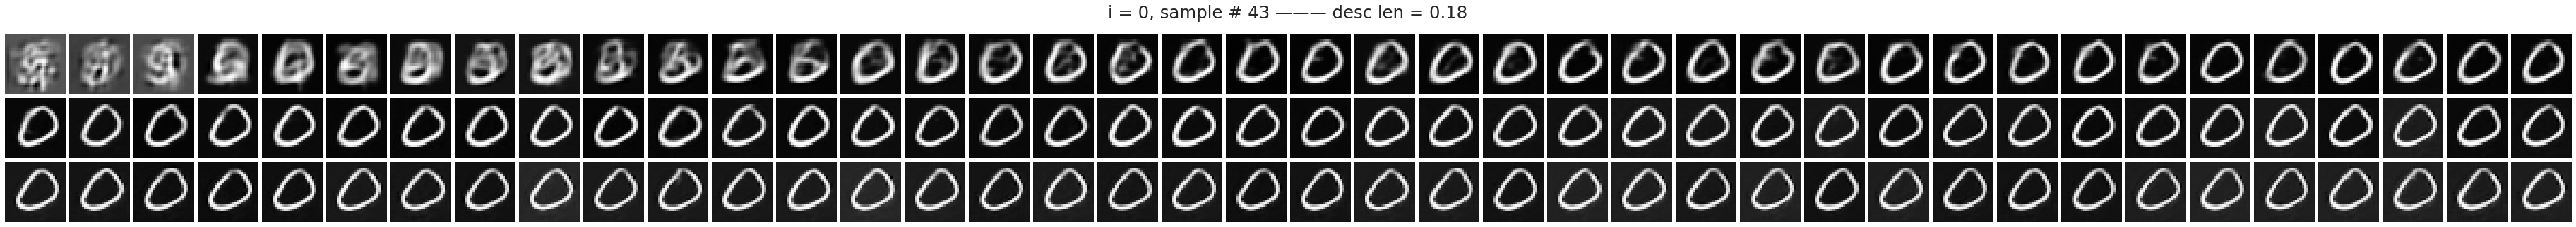

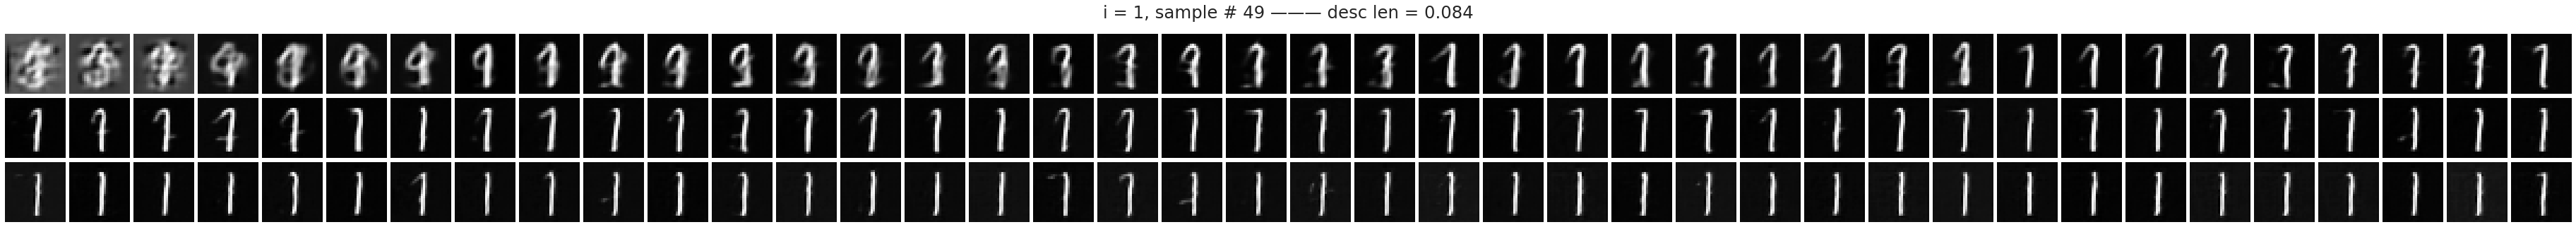

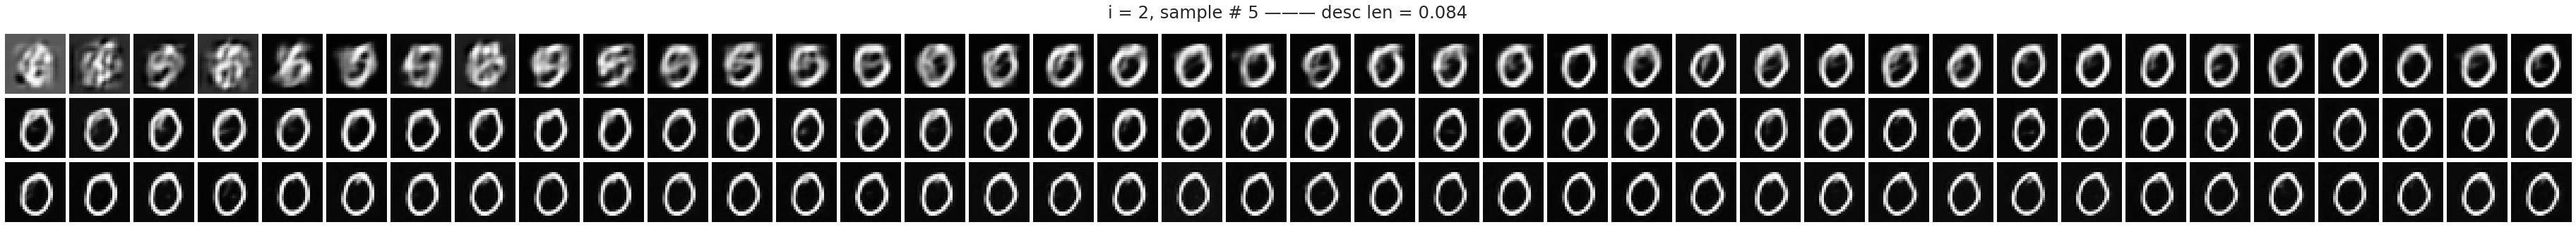

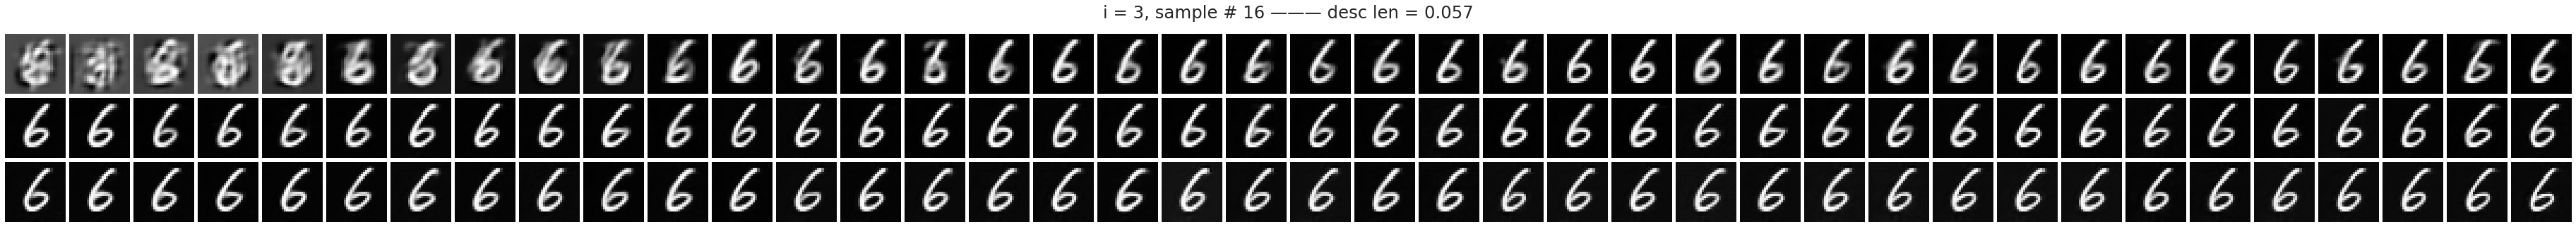

In [13]:
for i in range(len(pred)):
    if i > 3:
        continue
    sample_i = order[i]
    nrows, ncols = 3, 40
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=70)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i])
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(y[sample_i, idx - 1])
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

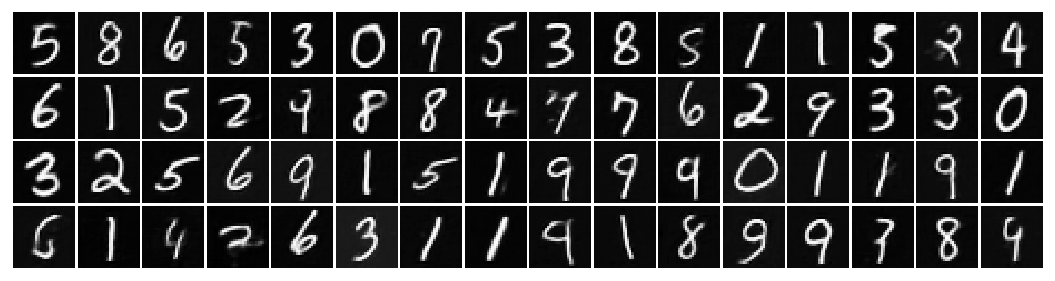

In [25]:
fig, ax = plot_weights(y[:, 80, ...], nrows=4, dpi=130)

### rotate & generate

In [86]:
def random_rotation_matrix(theta: float = 15, qr: bool = True):
    theta = np.deg2rad(theta)
    a = torch.randn(128, 128)
    
    if qr:
        q, r = torch.linalg.qr(a)
        det_q = torch.det(q)
        if det_q < 0:
            q[:, 0] = -q[:, 0]
        return q
    else:
        a = a - a.T
        a = (theta / torch.norm(a, 'fro')) * a
        a = torch.matrix_exp(a)
        return a

In [87]:
n_samples = 64
tr.model.reset_state(n_samples)

# permute
# inds = torch.randperm(tr.model.layer.dim)
# tr.model.layer.state = tr.model.layer.state[:, inds]

# rotate
# a = tr.to(random_rotation_matrix(30, False))
# tr.model.layer.state = tr.model.layer.state @ a

# silece
silence_inds = np.arange(128)
state = tonp(tr.model.layer.state)
state[:, silence_inds] = -20

tr.model.layer.state.data = tr.to(state)

# generate first samples
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

In [88]:
n_iters = 200
output = tr.model.generate(pred, seq=range(n_iters))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['loss_kl', 'loss_recon', 'dist', 'ff', 'recon', 'state', 'samples']

In [89]:
shape = (n_samples, *tr.model.cfg.input_sz[1:])
pred = pred.reshape(shape)

shape_y = (n_samples, n_iters, *tr.model.cfg.input_sz[1:])
y = output['recon'].reshape(shape_y)

pred.shape, y.shape

(torch.Size([64, 28, 28]), torch.Size([64, 200, 28, 28]))

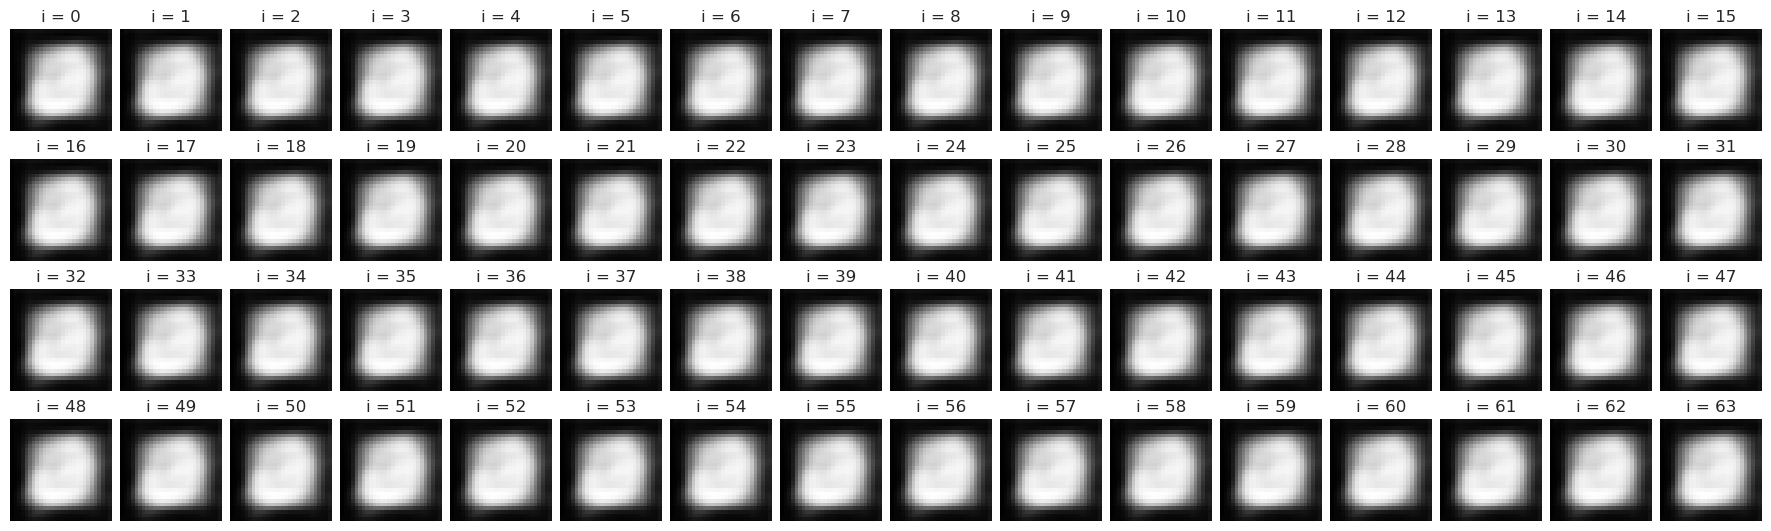

In [90]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')

for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    
    x2p = tonp(pred[sample_i])
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")

trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [91]:
order = np.argsort(desc_len)[::-1]

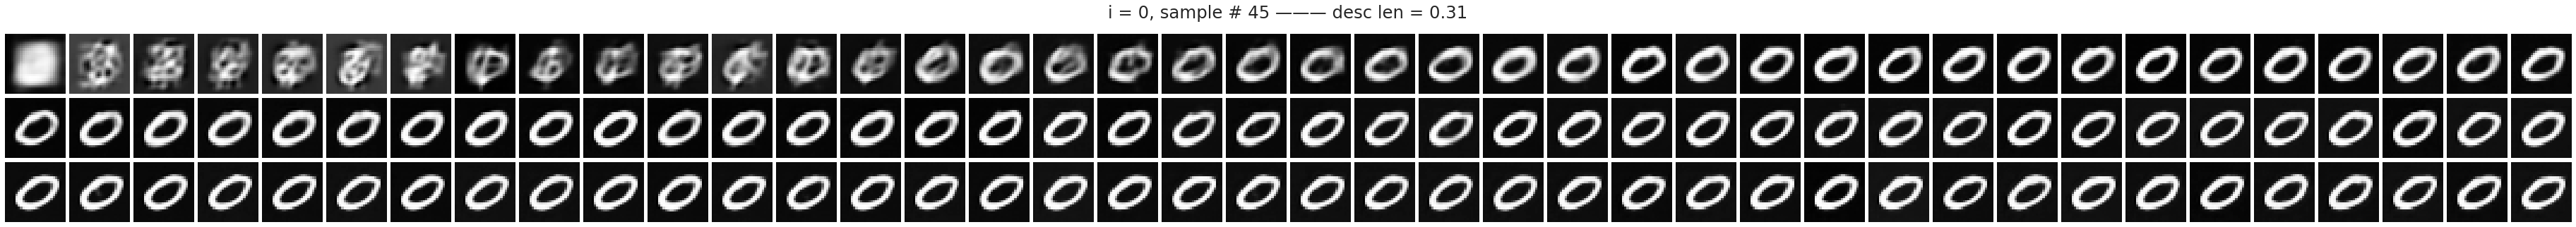

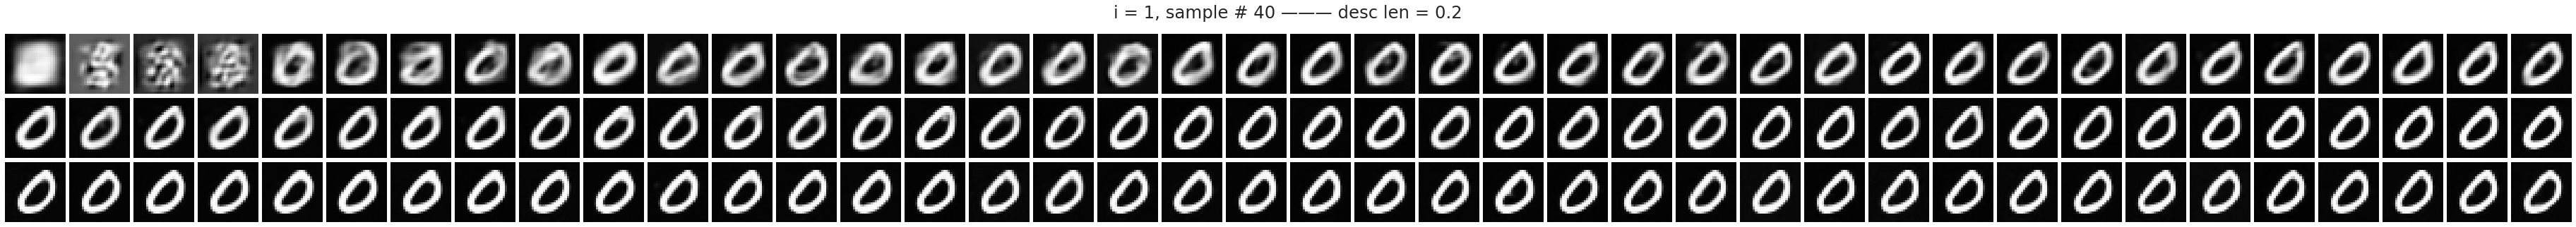

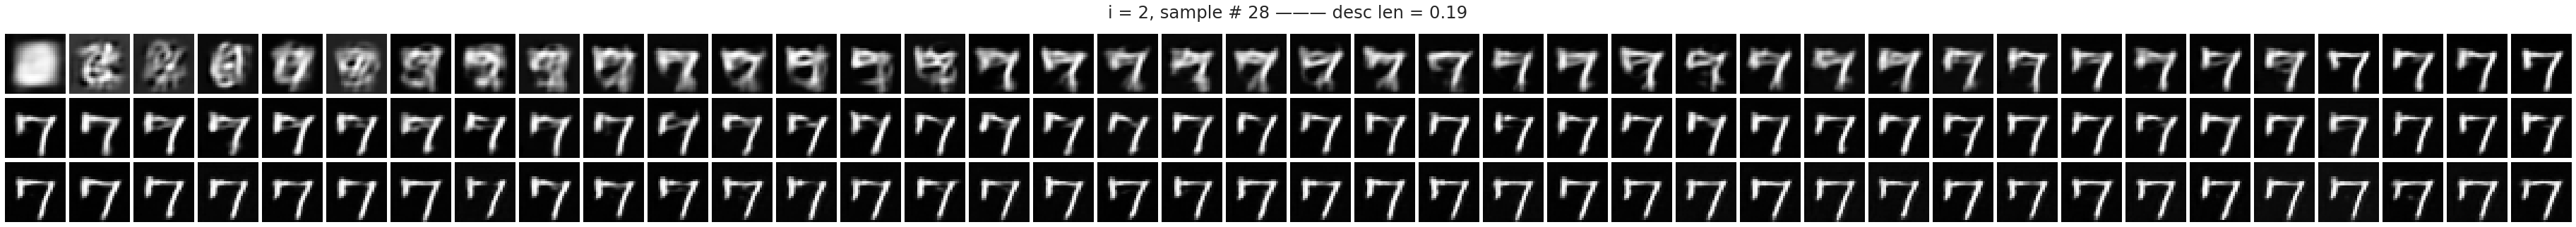

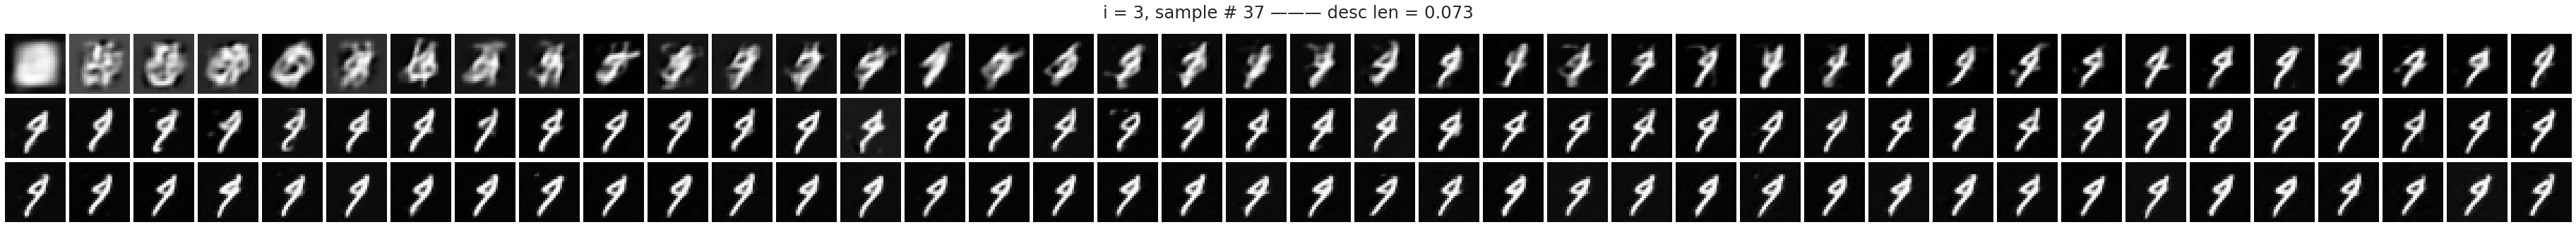

In [92]:
for i in range(len(pred)):
    if i > 3:
        continue
    sample_i = order[i]
    nrows, ncols = 3, 40
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=70)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i])
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(y[sample_i, idx - 1])
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

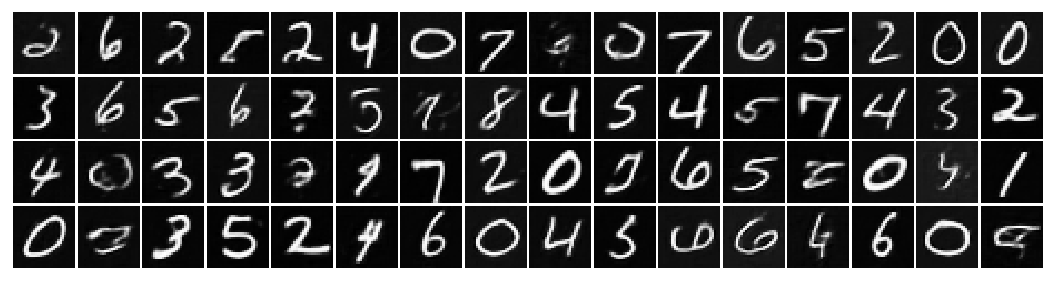

In [94]:
fig, ax = plot_weights(y[:, 80, ...], nrows=4, dpi=130)

### generate from noise?

In [34]:
from base.distributions import Poisson

In [35]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)

tr.model.pred.normal_(0.0, 1.0)
tr.model.layer.state = torch.randn_like(tr.model.state)

pred = tr.model.pred
# pred = torch.zeros_like(tr.model.pred)

In [36]:
n_iters = 200
output = tr.model.generate(pred, seq=range(n_iters))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['loss_kl', 'loss_recon', 'dist', 'ff', 'recon', 'state', 'samples']

In [37]:
shape = (n_samples, *tr.model.cfg.input_sz[1:])
pred = pred.reshape(shape)

shape_y = (n_samples, n_iters, *tr.model.cfg.input_sz[1:])
y = output['recon'].reshape(shape_y)

pred.shape, y.shape

(torch.Size([64, 28, 28]), torch.Size([64, 200, 28, 28]))

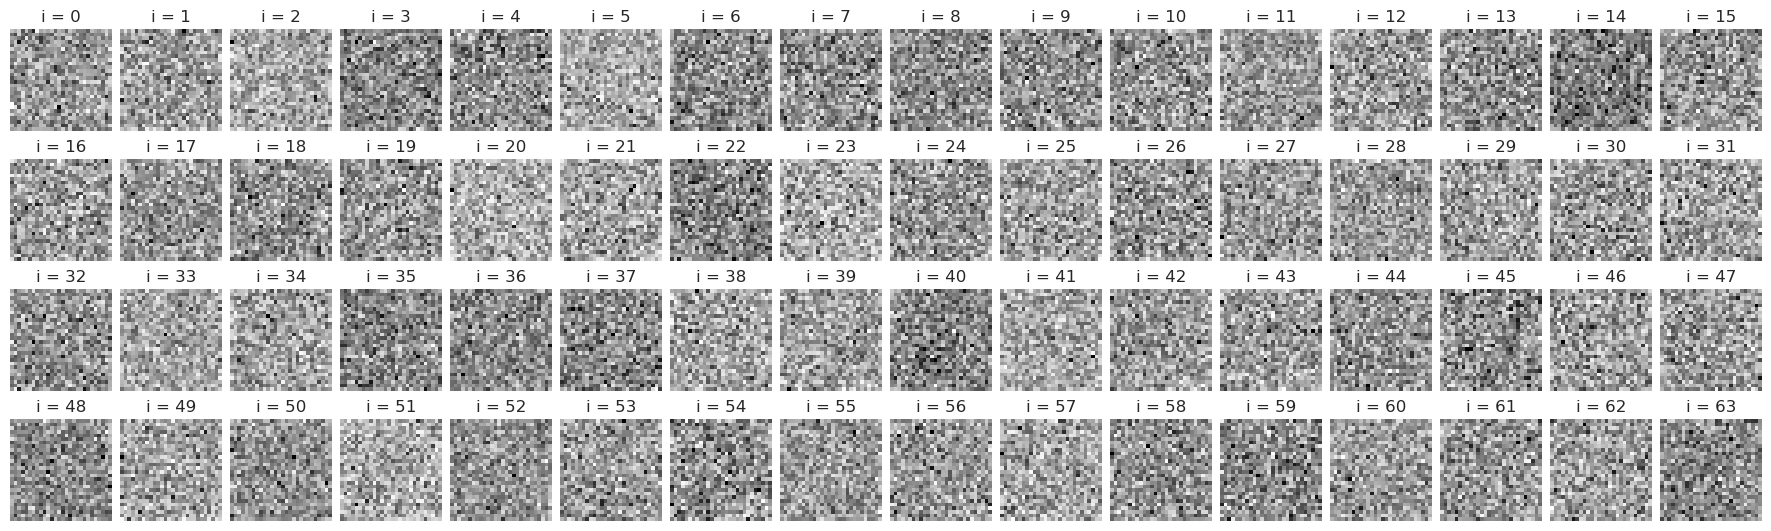

In [38]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')

for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    
    x2p = tonp(pred[sample_i])
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")

trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [39]:
order = np.argsort(desc_len)[::-1]

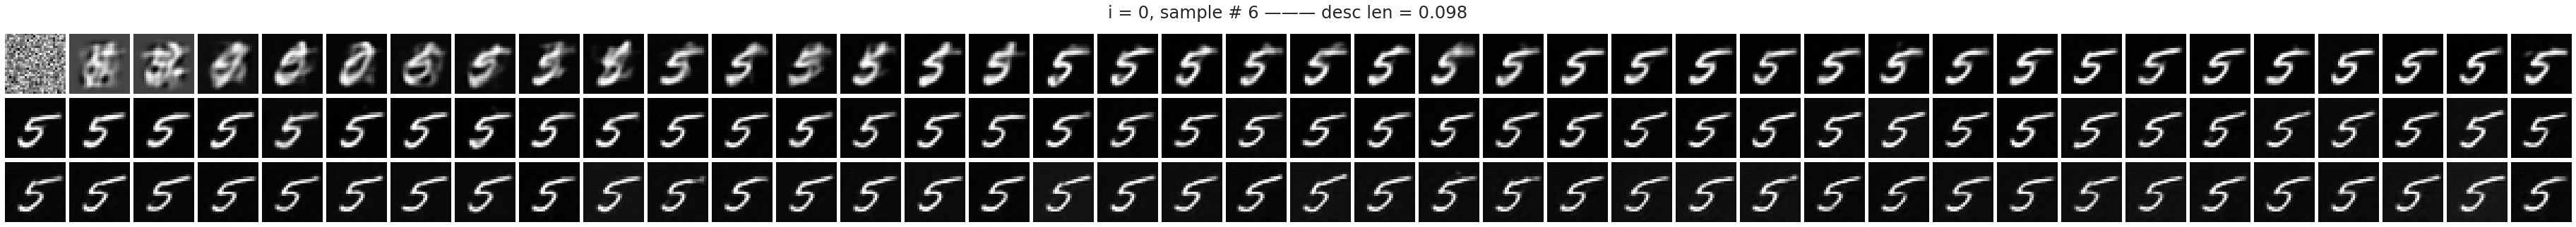

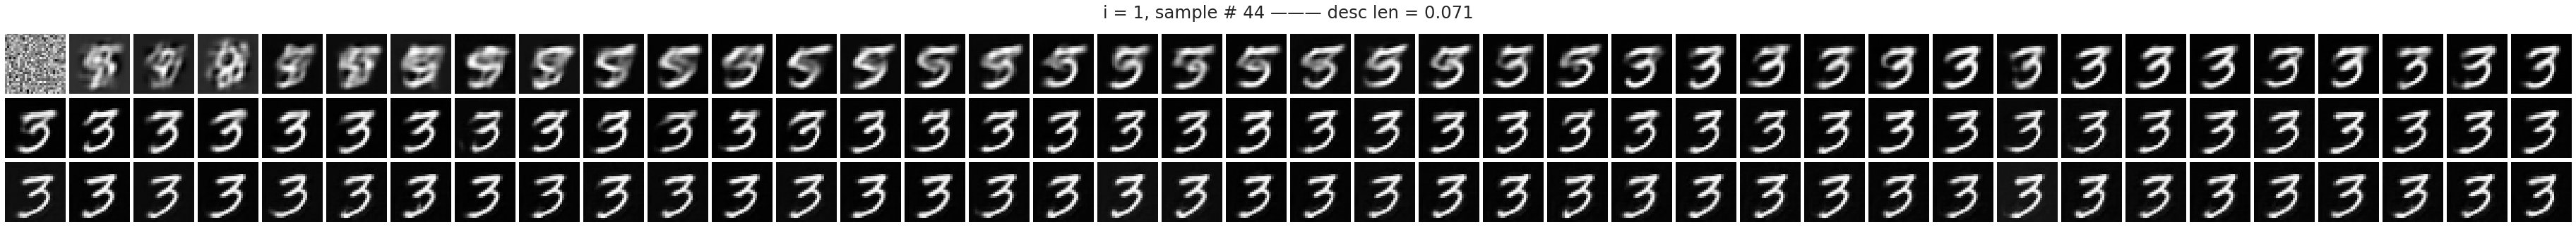

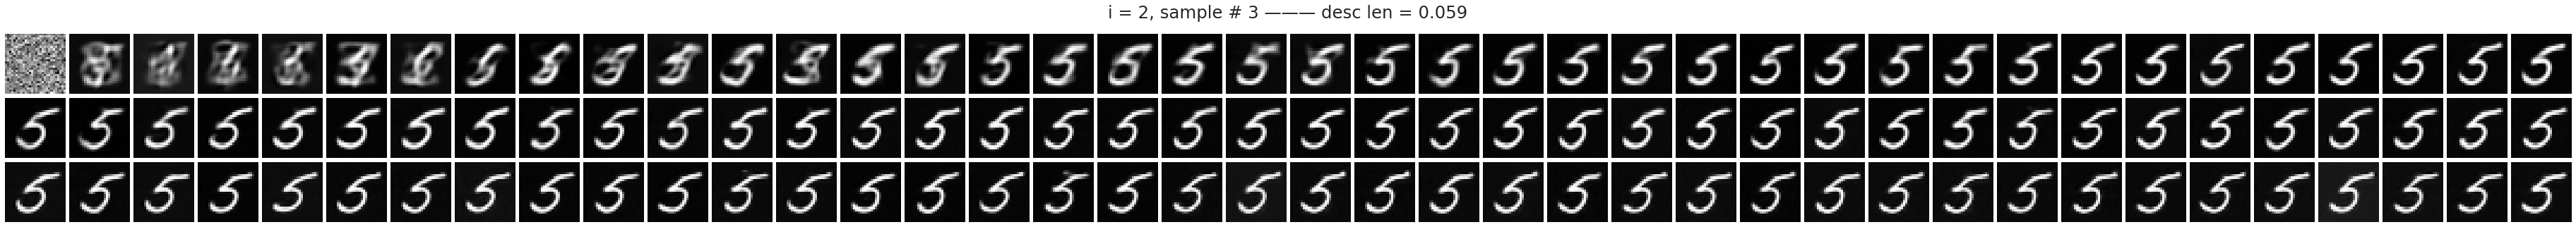

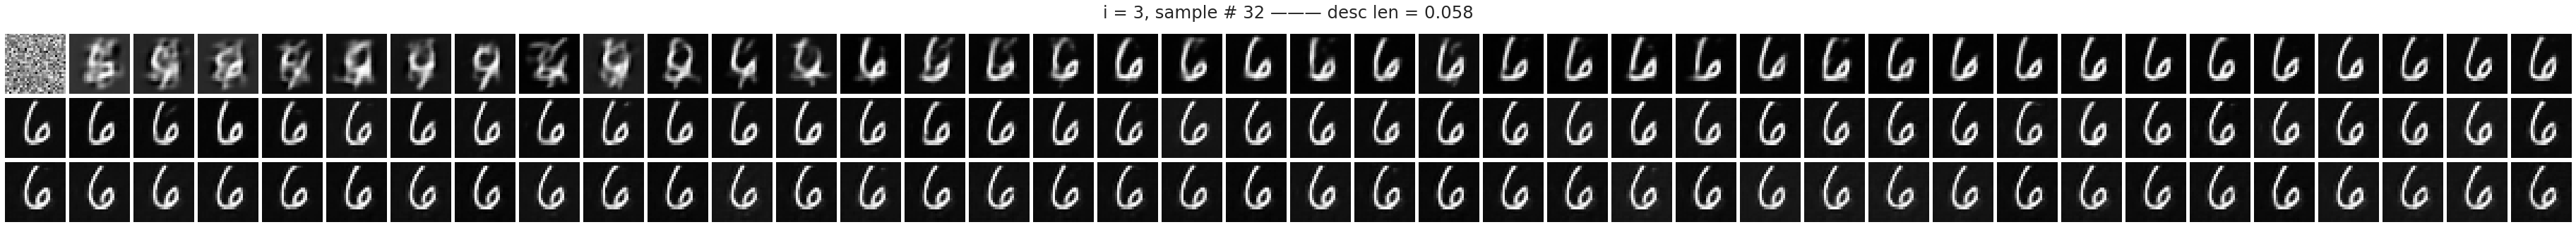

In [40]:
for i in range(len(pred)):
    if i > 3:
        continue
    sample_i = order[i]
    nrows, ncols = 3, 40
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=70)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i])
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(y[sample_i, idx - 1])
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

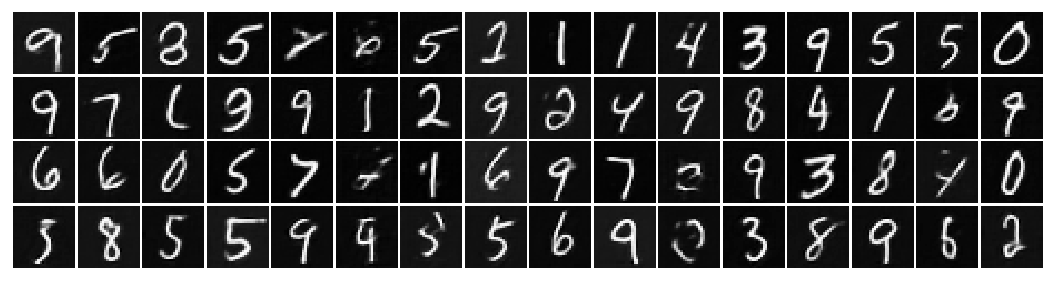

In [42]:
fig, ax = plot_weights(y[:, 80, ...], nrows=4, dpi=130)

### generate from zeros?

In [17]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)

tr.model.pred.fill_(0.0)
tr.model.samples.fill_(0.0)
tr.model.posterior.rate.fill_(1e-6)

pred = tr.model.pred
# pred = torch.zeros_like(tr.model.pred)

In [18]:
n_iters = 200
output = tr.model.generate(pred, seq=range(n_iters))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['loss_kl', 'loss_recon', 'dist', 'ff', 'recon', 'state', 'samples']

In [19]:
shape = (n_samples, *tr.model.cfg.input_sz[1:])
pred = pred.reshape(shape)

shape_y = (n_samples, n_iters, *tr.model.cfg.input_sz[1:])
y = output['recon'].reshape(shape_y)

pred.shape, y.shape

(torch.Size([64, 28, 28]), torch.Size([64, 200, 28, 28]))

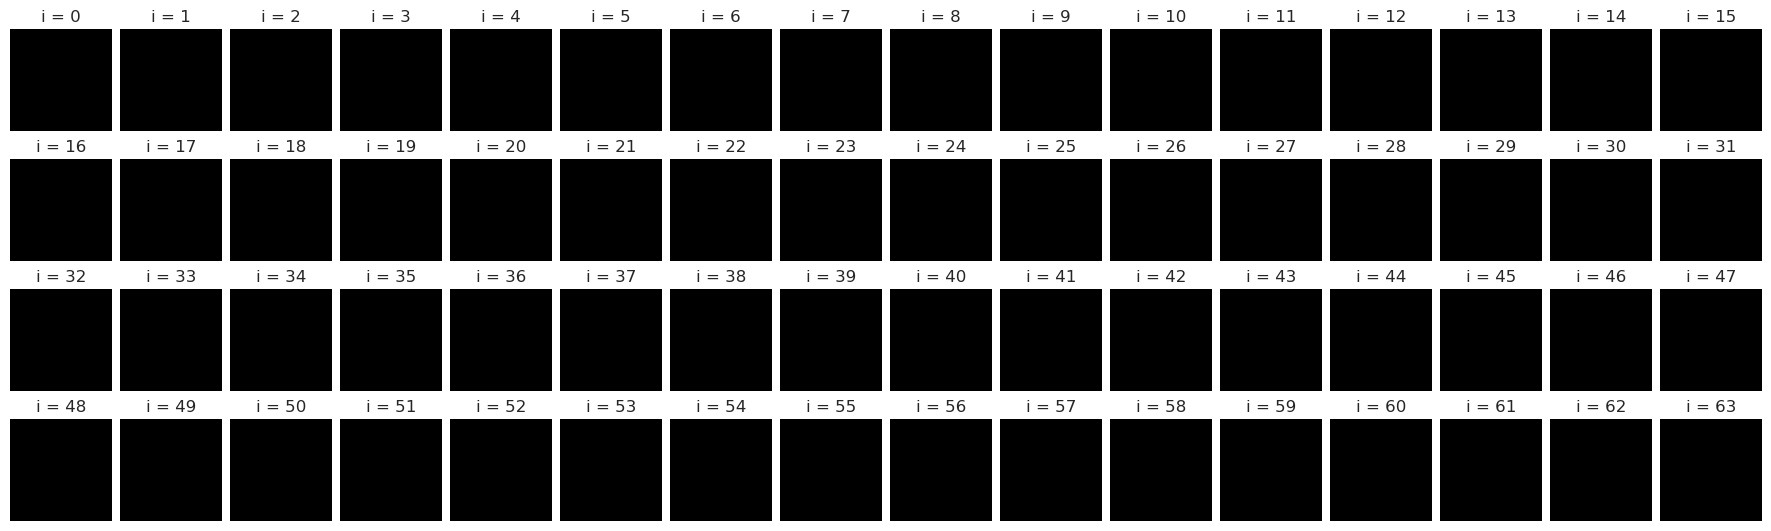

In [20]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')

for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    
    x2p = tonp(pred[sample_i])
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")

trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [21]:
order = np.argsort(desc_len)[::-1]

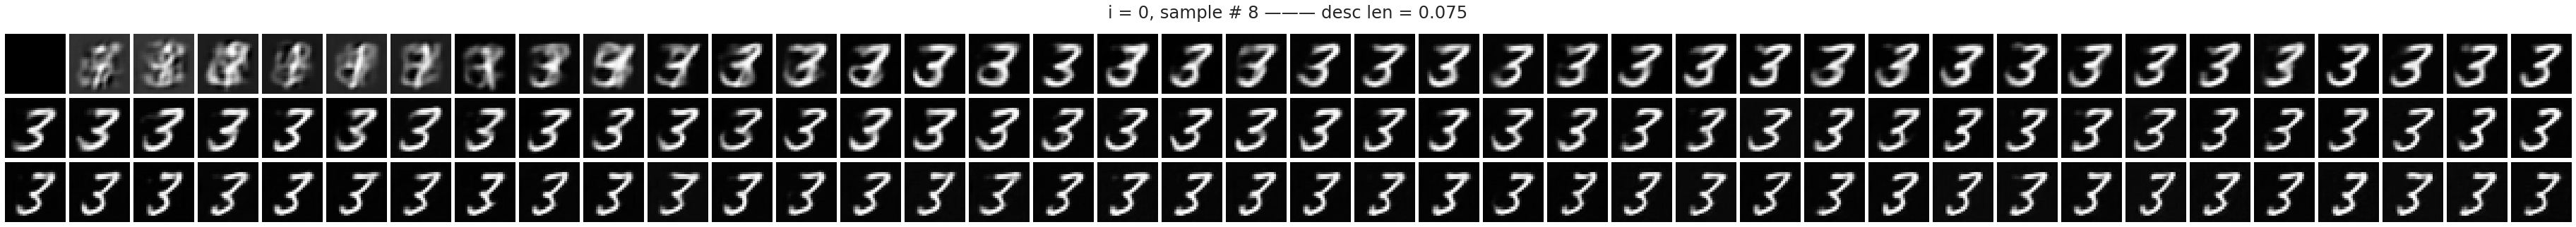

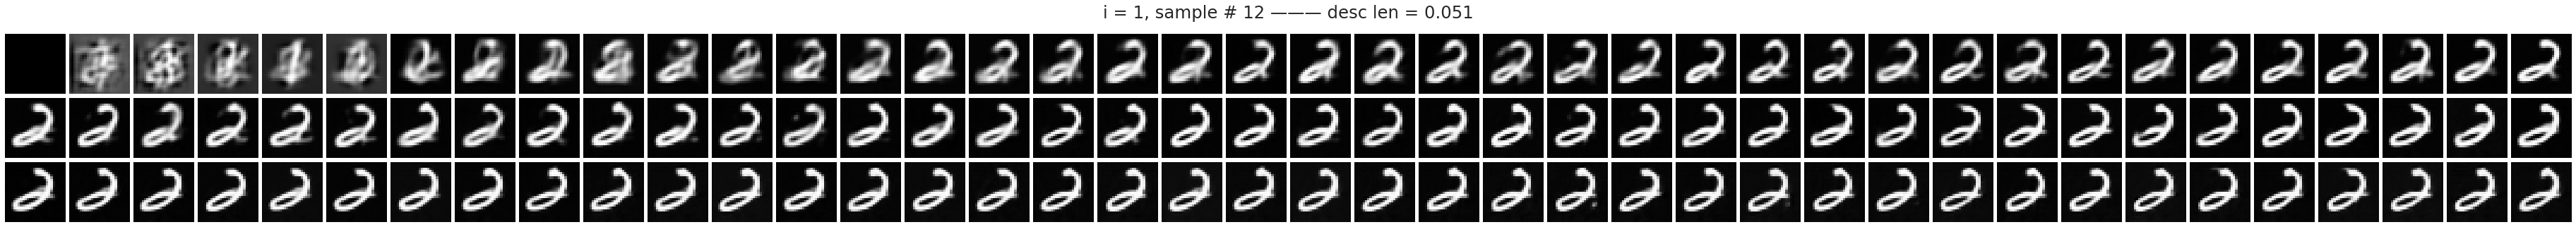

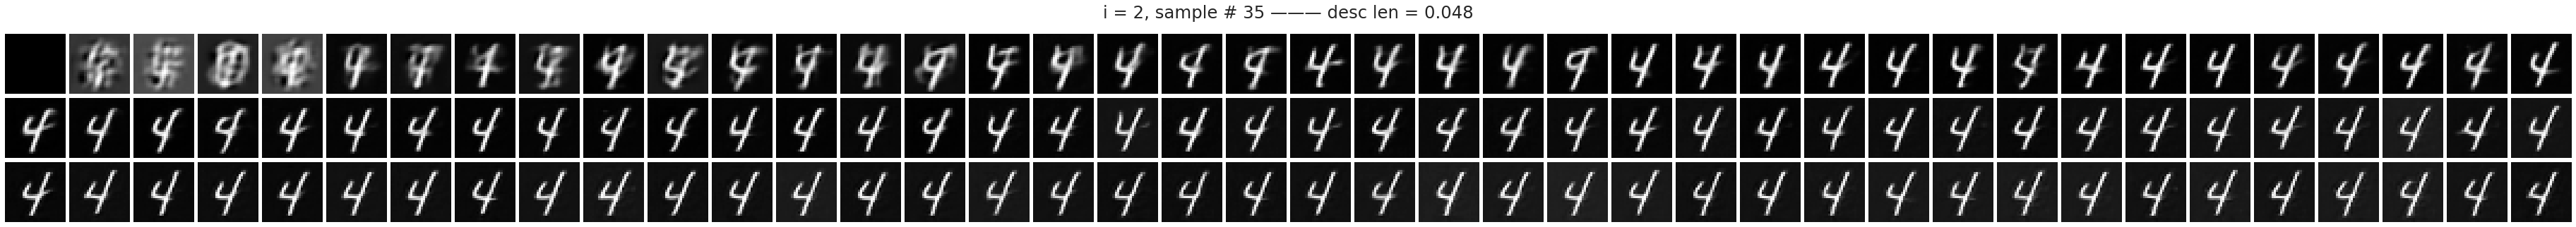

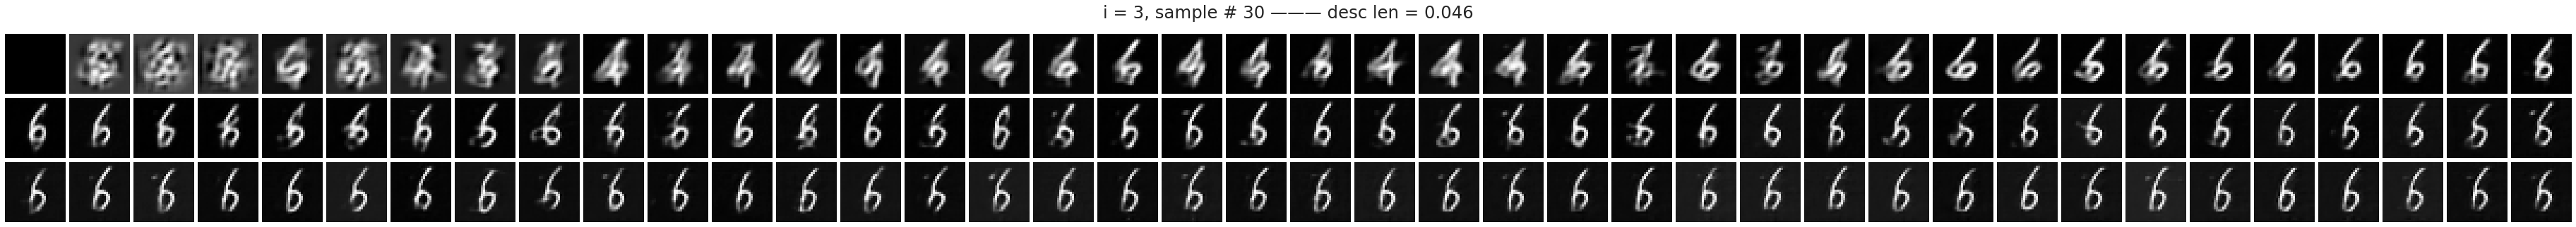

In [22]:
for i in range(len(pred)):
    if i > 3:
        continue
    sample_i = order[i]
    nrows, ncols = 3, 40
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=70)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i])
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(y[sample_i, idx - 1])
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

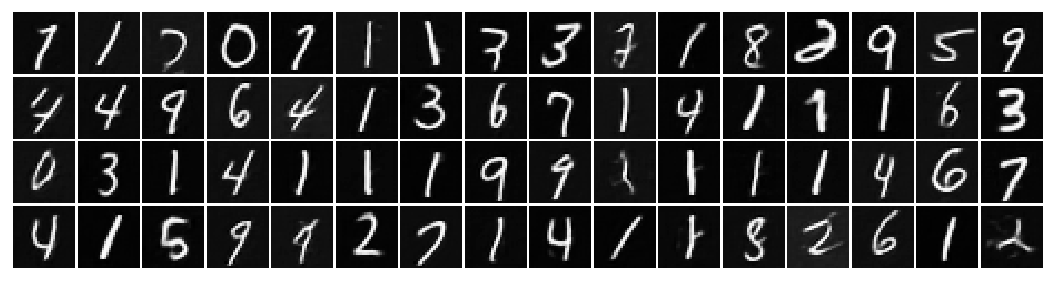

In [23]:
fig, ax = plot_weights(y[:, 80, ...], nrows=4, dpi=130)